In [ ]:
#@title Deep Learning Project : Plant Leave disease analysis


In [ ]:
####################################### IMPORTS ###################################

In [ ]:
import numpy as np
import pickle
import cv2
import os
import tensorflow as tf
import pandas as pd
from os import listdir
import tensorflow_datasets as tfds
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.layers import BatchNormalization
from keras import backend as K
from keras.optimizers import Adam
from tensorflow.keras.utils import img_to_array
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from google.colab.patches import cv2_imshow


import warnings
warnings.filterwarnings('ignore')

In [ ]:
#####################################STORAGE MOUNT ##############################

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
rootDir="./drive/MyDrive/DP/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
################################## DOWNLOAD/LOAD DATASET ############################

In [ ]:
#skip if already downloaded


#ds = tfds.load('plant_village', download=True,data_dir=rootDir+"data/plant_village/1.0.2", shuffle_files=True)
#print(ds)


In [ ]:
#load the dataset
#./drive/MyDrive/DP/try3/data/plant_village/1.0.2/plant_village/1.0.2
downloadDir="./drive/MyDrive/DP/try3/data/extracted/plant_village/"
#ds = tfds.load('plant_village', download=False,data_dir=downloadDir, shuffle_files=True)



In [ ]:
def readAndConvertImage(image_dir):
  try:
      image = cv2.imread(image_dir)
      if image is not None :
          image = cv2.resize(image, default_size)
          return img_to_array(image)
      else :
          return np.array([])
  except Exception as e:
      print(e)
      return None


def loadData1(rootDir):
  i=0
  with tf.device('/GPU:0'):
    try:
      root_dir = listdir(rootDir)
      for plant_folder in root_dir :
          plant_disease_folder_list = listdir(f"{rootDir}/{plant_folder}")
          print(plant_folder)
          for image in plant_disease_folder_list[:limitItems]:
                image_directory = f"{rootDir}/{plant_folder}/{image}"
                imageList.append(readAndConvertImage(image_directory))
                labelList.append( plant_folder)
    except Exception as e:
      print(e)

In [ ]:
default_size = tuple((256, 256))
#limit images per class
limitItems=200
imageList, labelList=[],[]
#loadData(rootDir+"data1/")

loadData1(rootDir+"data1/Plant_leave_diseases_dataset")


Corn___healthy
Peach___Bacterial_spot
Apple___Apple_scab
Apple___Black_rot
Apple___Cedar_apple_rust
Apple___healthy
Background_without_leaves
Blueberry___healthy
Cherry___healthy
Cherry___Powdery_mildew
Corn___Cercospora_leaf_spot Gray_leaf_spot
Corn___Common_rust
Corn___Northern_Leaf_Blight
Grape___Black_rot
Grape___Esca_(Black_Measles)
Grape___healthy
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
Orange___Haunglongbing_(Citrus_greening)


In [ ]:
############################## VISUALISE DATA ##########################################

In [ ]:

lableList=pd.DataFrame(labelList)
uniqueClasses=lableList[0].nunique()

print("UNIQUE Lable classes",uniqueClasses)


UNIQUE Lable classes 16


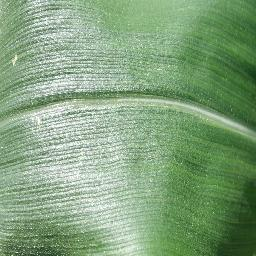

In [ ]:

cv2_imshow(imageList[0])
default_image_size=imageList[0].shape
print("Default Image Size:" ,default_image_size)
print("TOTAL DATA length:",len(imageList))


In [ ]:
########################### DATA PRE PROCESSING ########################################

Default Image Size: (256, 256, 3)
TOTAL DATA length: 3200


In [ ]:
#Lable
labelBin = LabelBinarizer()
imageLabel = labelBin.fit_transform(labelList)
pickle.dump(labelBin,open(rootDir+'/try3/labels.pkl', 'wb'))
uniqueClasses = len(labelBin.classes_)
#pd.DataFrame(image_labels).to_csv(rootDir+'image_labels.csv')
#image_labels

In [ ]:
imageLabel[:1]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]])

In [ ]:
device_name = tf.test.gpu_device_name()
print(device_name)
print('Found GPU at: {}'.format(device_name))

/device:GPU:0
Found GPU at: /device:GPU:0


In [ ]:
#images
with tf.device('/device:GPU:0'):
  np_image_list = np.array(imageList, dtype=np.float16) / 225.0
  #pd.DataFrame(np_image_list).to_csv(rootDir+'np_image_list.csv')

In [ ]:
# Load from Disk

#imageLabels=pd.read_csv(rootDir+"imageLabel.csv",  index_col=None).to_numpy()
#npImageList=pd.read_csv(rootDir+"np_imageList.csv",  index_col=None).to_numpy()



In [ ]:
########################### SPLITING DATA FOR TEST AND TRAIN ########################################

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(np_image_list, imageLabel, test_size=0.2, random_state = 42)
print("Training sample :",len(x_train))
print("Testing sample :",len(x_test))

Training sample : 2560
Testing sample : 640


In [ ]:
################################ BUILDING MODELS #################################################

In [ ]:
# Model 1 : CNN
model = Sequential()
inputShape = default_image_size
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = default_image_size
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Flatten()) # image input
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(uniqueClasses)) # as no of classes
model.add(Activation("softmax"))# as multiclass
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 activation (Activation)     (None, 256, 256, 32)      0         
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 85, 85, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 231200)            0         
                                                                 
 dense (Dense)               (None, 1024)              2

In [ ]:
################################ TRAINING THE MODEL #################################################

In [ ]:
# Include the epoch in the file name (uses `str.format`)
checkpoint_path = rootDir+"try3/training_2/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

batch_size = 32

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq=5*batch_size)





epochs=100

lr=1e-3
with tf.device('/GPU:0'):
  opt = Adam(lr=lr, decay=lr / epochs)
  model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

  history = model.fit(x_train, y_train, epochs=100,callbacks=[cp_callback],
                    validation_data=(x_test, y_test))


Epoch 1/100
80/80 [==============================] - 15s 61ms/step - loss: 0.6840 - accuracy: 0.3973 - val_loss: 0.3290 - val_accuracy: 0.2094
Epoch 2/100
79/80 [============================>.] - ETA: 0s - loss: 0.2494 - accuracy: 0.6123
Epoch 2: saving model to ./drive/MyDrive/DP/try3/training_2/cp-0002.ckpt
80/80 [==============================] - 16s 208ms/step - loss: 0.2481 - accuracy: 0.6129 - val_loss: 0.1956 - val_accuracy: 0.3406
Epoch 3/100
80/80 [==============================] - 3s 39ms/step - loss: 0.1156 - accuracy: 0.7828 - val_loss: 0.2043 - val_accuracy: 0.2672
Epoch 4/100
79/80 [============================>.] - ETA: 0s - loss: 0.0774 - accuracy: 0.8647
Epoch 4: saving model to ./drive/MyDrive/DP/try3/training_2/cp-0004.ckpt
80/80 [==============================] - 41s 521ms/step - loss: 0.0772 - accuracy: 0.8645 - val_loss: 0.1951 - val_accuracy: 0.3250
Epoch 5/100
80/80 [==============================] - 4s 50ms/step - loss: 0.0565 - accuracy: 0.9129 - val_loss: 0.1

In [ ]:
################################ EVALUATE MODEL #################################################

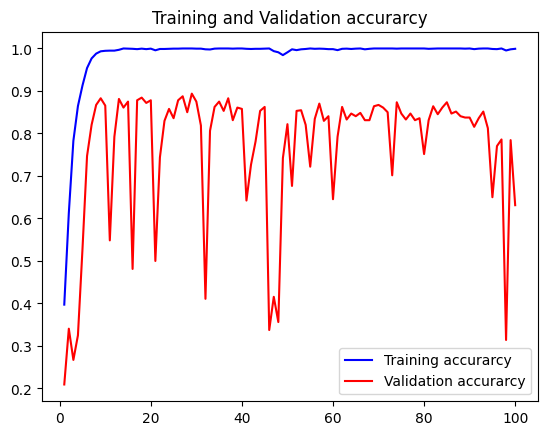

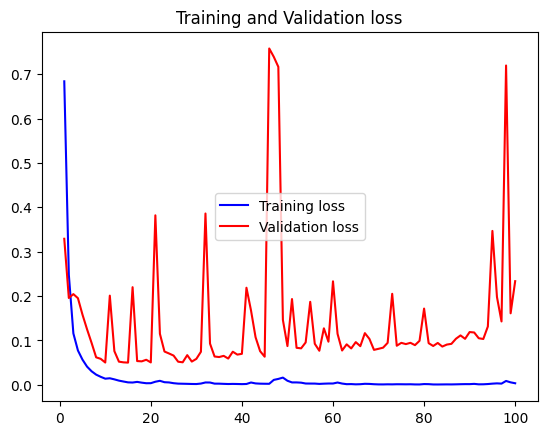

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'blue', label='Training accurarcy')
plt.plot(epochs, val_acc, 'red', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'blue', label='Training loss')
plt.plot(epochs, val_loss, 'red', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [ ]:
print("Accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

Accuracy
20/20 [==============================] - 0s 15ms/step - loss: 0.2335 - accuracy: 0.6313
Test Accuracy: 63.12500238418579


In [ ]:
checkpoint_dir = rootDir+"try3/training_2/"
os.listdir(checkpoint_dir)

['cp-0000.ckpt.data-00000-of-00001',
 'cp-0000.ckpt.index',
 'checkpoint',
 'cp-0002.ckpt.data-00000-of-00001',
 'cp-0002.ckpt.index',
 'cp-0003.ckpt.data-00000-of-00001',
 'cp-0003.ckpt.index',
 'cp-0004.ckpt.data-00000-of-00001',
 'cp-0004.ckpt.index',
 'cp-0005.ckpt.data-00000-of-00001',
 'cp-0005.ckpt.index',
 'cp-0006.ckpt.data-00000-of-00001',
 'cp-0006.ckpt.index',
 'cp-0007.ckpt.data-00000-of-00001',
 'cp-0007.ckpt.index',
 'cp-0008.ckpt_temp',
 'cp-0003.ckpt_temp',
 'cp-0001.ckpt.data-00000-of-00001',
 'cp-0001.ckpt.index',
 'cp-0001.ckpt_temp',
 'cp-0008.ckpt.data-00000-of-00001',
 'cp-0008.ckpt.index',
 'cp-0010.ckpt.data-00000-of-00001',
 'cp-0010.ckpt.index',
 'cp-0012.ckpt.data-00000-of-00001',
 'cp-0012.ckpt.index',
 'cp-0014.ckpt.data-00000-of-00001',
 'cp-0014.ckpt.index',
 'cp-0016.ckpt.data-00000-of-00001',
 'cp-0016.ckpt.index',
 'cp-0018.ckpt.data-00000-of-00001',
 'cp-0018.ckpt.index',
 'cp-0020.ckpt.data-00000-of-00001',
 'cp-0020.ckpt.index',
 'cp-0022.ckpt.data

In [ ]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

'./drive/MyDrive/DP/try3/training_2/cp-0100.ckpt'

In [ ]:
#58
bestWeight='./drive/MyDrive/DP/try3/training_2/cp-0024.ckpt'

In [ ]:

resetModel = model

resetModel.load_weights(bestWeight)

loss, acc = resetModel.evaluate(x_test, y_test, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

20/20 - 0s - loss: 0.0704 - accuracy: 0.8578 - 295ms/epoch - 15ms/step
Restored model, accuracy: 85.78%


In [ ]:
# save the model to disk
modelDir=rootDir+'try3/model/'+'my_model.h5'
resetModel.save(modelDir)
#pickle.dump(model,open(rootDir+'try3/cnn_model.pkl', 'wb'))

In [ ]:
################################ TESTING THE MODEL #################################################

In [ ]:
#model load
modelDir=rootDir+'try3/model/'+'my_model.h5'
new_model = tf.keras.models.load_model(modelDir)
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 activation (Activation)     (None, 256, 256, 32)      0         
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 85, 85, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 231200)            0         
                                                                 
 dense (Dense)               (None, 1024)              2

In [ ]:

default_size = tuple((256, 256))

filename = rootDir+'/try3/labels.pkl'
image_labels = pickle.load(open(filename, 'rb'))

def predict_disease(image_path):
    print(image_path)
    image_array = readAndConvertImage(image_path)
    np_image = np.array(image_array, dtype=np.float16) / 225.0
    np_image = np.expand_dims(np_image,0)
    cv2_imshow(image_array)
    result = new_model.predict(np_image)
    print((image_labels.inverse_transform(result)))


./drive/MyDrive/DP/test/corn_healthy.jpg


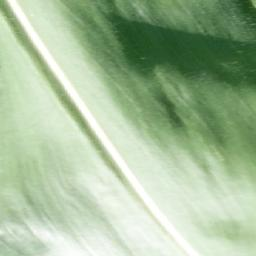

1/1 [==============================] - 0s 24ms/step
['Corn___healthy']


In [ ]:
testImagesDir=["corn_healthy.jpg","applerust.JPG"]
predict_disease(rootDir+'test/'+testImagesDir[0])

./drive/MyDrive/DP/test/applerust.JPG


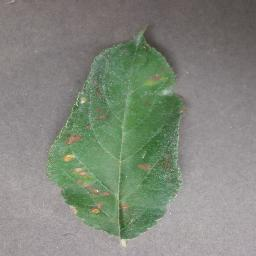

1/1 [==============================] - 0s 24ms/step
[[3.5210894e-09 1.9385940e-09 9.9998784e-01 1.5895143e-06 5.6577969e-09
  1.5724349e-06 3.0885224e-07 8.5538741e-06 6.1193224e-09 5.1366797e-08
  3.2727148e-09 7.0024520e-10 5.2291266e-12 5.4073026e-09 1.1437673e-09
  3.9977328e-09]]
['Apple___Cedar_apple_rust']


In [ ]:
predict_disease(rootDir+'test/'+testImagesDir[1])